# INF8775 – Analyse et conception d’algorithmes
# TP2 – Hiver 2024

Lominy, Michel, 2074487

OURAHMOUNE, Mahdi, 2083329

Note finale :

 <u>**Date limite de remise :**</u>  27 mars 23h59 (Groupe B1), 19 mars 23h59 (Groupe B2)

# Instructions

## Rédaction et remise du rapport

- Ce notebook constitue à la fois le sujet du TP, votre code et votre rapport. Il contient déjà du code pour faciliter vos mesures et l'affichage de vos résultats, ainsi qu'un squelette pour votre rapport.

- Complétez directement le notebook, vous êtes libres de créer de nouvelles cellules de code ou de texte. 

- Remettez le fichier du notebook sur Moodle avec le nom `NOM1_MATRICULE1_NOM2_MATRICULE2.ipynb`

- Vous pouvez inclure du code trouvé sur Internet, mais vous devez en mentionner la source, sous peine d'être sanctionnés pour plagiat.

## Mise en situation

Ce travail pratique se répartit sur deux séances de laboratoire et porte sur l'analyse et la conception d'algorithmes développés suivant différents patrons de conception afin de résoudre une version simplifiée d'un problème réaliste d'optimisation.


## Description du problème

Un pianiste souhaite jouer une mélodie donnée par une partition. La mélodie est une suite de n notes *(a0, a1, ... , an-1)* où chaque ai appartient à un ensemble de m notes numérotées de 0 à m-1.

Le pianiste peut choisir de jouer chaque note avec l’un de ses D doigts. Le passage de la note i1 jouée avec le doigt d1 à la note i2 jouée avec le doigt d2 est pénalisée par une fonction de difficulté de la transition *C(i1, d1, i2, d2)*. Notre pianiste souhaite donc déterminer avec quel doigt il doit jouer chaque note de la mélodie de façon à minimiser la somme des coûts de chaque transition.

Pour la partie empirique de ce TP, nous nous limiterons à des mélodies jouées à une main (D=5) sur deux octaves (m=24).

Soit l’exemple suivant avec 5 notes :

- L'exemplaire est : `[17, 21, 18, 2, 21, 15, 11, 16]`
- La solution est : `[2, 1, 1, 0, 1, 1, 2, 1]`

La figure ci-dessous représente la partition avec ça solution et le coût associé à chaque transition (en gris).

![alt text](example_solution.png "Title")

## Algorithmes à implanter

Trois algorithmes seront implantés, mettant en pratique des patrons de conception différents :

1. Un algorithme glouton
2. Un algorithme de programmation dynamique
3. Un algorithme de recherche locale


## Jeu de données

La fonction `generate_sample` ci-dessous permet de générer un exemplaire d'une taille donnée.

La fonction `get_dataset` permet de récupérer un dataset pour la liste de taille fournie. Elle prend également en entrée un graine aléatoire pour générer le dataset en question.

Afin que chaque groupe travaille avec un set différent, mais que vos propres expériences soient reproductibles, entrez l'un de vous matricule comme graine aléatoire dans la cellule ci-dessous.

Vous êtes bien entendu libres de tester et mesurer vos algorithme sur le même dataset qu'un autre groupe. Pour cela, générez simplement un dataset avec la même graine et la même liste de taille.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress
import time

In [2]:
def visualize_solution(costs, partition, solution):
    """
    Visualisez votre solution et les coûts associés.    
    """
    # Create a figure and axis
    _, ax = plt.subplots()
    
    # Plot the notes as circles with their sizes proportional to the partition values
    for i in range(len(partition)):
        ax.scatter([i], [partition[i]], marker='o')
        ax.text(i, partition[i] + 0.2, str(solution[i]), ha='center', va='bottom')
    
    # Set the limits for the axes to fit the plot
    ax.set_ylim(min(partition) - 1, max(partition) + 1)
    ax.set_xlim(-0.5, len(partition)-0.5)
    
    # Label the axes
    ax.set_xlabel('Partition')
    ax.set_ylabel('Note')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Title the plot
    ax.set_title('Partition et doigts utilisés')

    plot_costs = getCosts(costs, partition, solution).tolist()
    plot_costs.append(0)

    ax2 = ax.twinx()
    ax2.bar(range(len(partition)), plot_costs, width=1, alpha=0.5, align='edge', color='gray')
    ax2.set_xlim(-0.5, len(partition)-0.5)
    ax2.set_ylim(0, 100)
    
    # Remove the ticks and tick labels from the secondary y-axis
    ax2.tick_params(axis='both', which='both', length=0)
    ax2.set_yticklabels([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)    
    # Show the plot
    plt.show()

def generate_sample(size, maxValue=24):
    return np.random.randint(0, maxValue, size).tolist()

def get_dataset(seed, sizes):
    np.random.seed(seed)
    return { size: [generate_sample(size) for _ in range(5)]
        for size in sizes }

def readFile(filePath):
    """
    Charger une partition depuis un fichier
    """
    f = open(filePath)
    N = int(f.readline())
    partition = list(map(int, f.readline().split(' ')))
    f.close()
    return partition

def getCosts(costs, partition, solution):
    """
    Liste des coûts associés à chaque transition de votre solution.
    """
    prevNotes, nextNotes = partition[:-1], partition[1:]
    prevFingers, nextFingers = solution[:-1], solution[1:]
    return costs[prevNotes, prevFingers, nextNotes, nextFingers]

def getTotalCost(costs, partition, solution):
    """
    Coût total de votre solution
    """
    return np.sum(getCosts(costs, partition, solution))

Exécutez la cellule suivante afin d'obtenir le tenseur des coûts associé à chaque transition.

In [3]:
load_file = np.loadtxt('cout_transition.txt', dtype=int)
costs = load_file.reshape((24, 5, 24, 5))
D = 5    # Nombre de doigts
M = 24   # Etendue des notes (2 octaves)

partition = readFile('Chansons/twinkle_twinkle.txt')

# Implantations et expérimentations

Ces fonctions auxiliaires vous sont fournies pour vérifier l'exactitude des vos algorithmes, mesurer leurs performance et afficher vos résultats.

Il est recommandé de prendre le temps de lire et comprendre le code.

Exécutez la cellule ci-dessous pour pouvoir utiliser les fonctions auxiliaires.

In [4]:
def measure(procedure, sample):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time(procedure, samples):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        _, compute_time = measure(procedure, sample)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure(procedure, dataset):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {size: measure_mean_time(procedure, samples) for size, samples in dataset.items()}

def display_measures_table(measures):
    print("{: <12} {: <12}".format("Taille", "Temps moyen (s)"))
    for size, measure in measures.items():
        print("{: <12} {: <12}".format(size, measure))


def display_test_puissance(vals, title="Test de puissance"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)
    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2f}x + {b:.2f}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('log Taille')
    plt.ylabel('log Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

def display_test_rapport(vals, title="Test du rapport"):
    x = list(vals.keys())
    y = list(vals.values())

    plt.plot(x, y, label='Mesures')
    plt.scatter(x, y, label='Mesures')

    # Add labels and title
    plt.xlabel('Taille')
    plt.ylabel('Temps / f(taille)')
    plt.title(title)
    plt.show()


def display_test_constantes(vals, title="Test des constantes"):
    x = list(vals.keys())
    y = list(vals.values())

    # Perform linear regression
    m, b, rvalue, _, _ = linregress(x, y)

    r = list(map(lambda x : m*x + b, x))

    # Create the line equation
    line_eq = f"y = {m:.2E}x + {b:.2E}"

    # Plot the points
    plt.scatter(x, y, label='Mesures')

    # Plot the regression line
    plt.plot(x, r, color="red", label=f'Regression linéaire R²={round(rvalue**2,4)}')

    # Add labels and title
    plt.xlabel('f(Taille)')
    plt.ylabel('Temps')
    plt.title(title)

    # Add legend
    plt.legend(bbox_to_anchor=(0.60, 0), loc='lower left')

    # Display the line equation
    plt.text(min(x), max(y), line_eq)

    # Show the plot
    plt.show()

In [5]:
import math

def values_test_puissance(measures):
    return {
        math.log(size) : math.log(measure)
        for size, measure in measures.items()
    }

def values_test_rapport(measures, f):
    return {
        size : (measure/f(size))
        for size, measure in measures.items()
    }


def values_test_constantes(measures, f):
    return {
        f(size) : measure
        for size, measure in measures.items()
    }

## Partie 1 : Algorithme glouton

Implantez un algorithme suivant le patron de conception glouton.

L'algorithme glouton fait son choix en fonction du coût de la prochaine transition :

Les deux premiers doigts d0 et d1 sont choisis de façon à minimiser C(a0, d0, a1, d1). Puis, étant donné le
doigt précédent d et la transition de la note i vers la note j, le choix glouton porte sur le doigt d’ qui
minimise C(i, d, j, d’).

Tentez de rendre votre implantation la plus performante possible en évitant des calculs inutiles.

Coût Glouton : 143


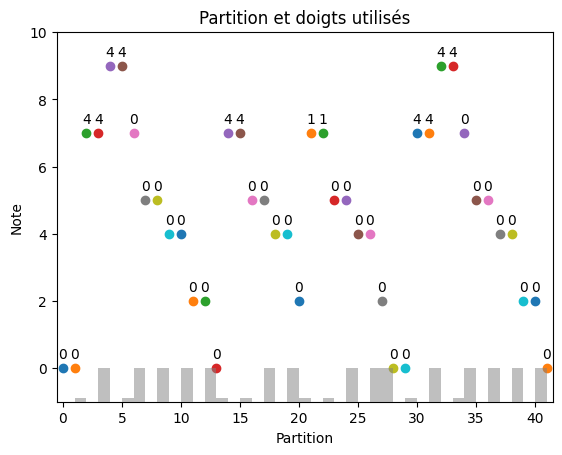

In [15]:
import math

def chooseFirst2Finger(a1, a2):
    min = math.inf
    d1 = 0
    d2 = 0
    for i in range(D):
        for j in range(D):
            if min > costs[a1, i, a2, j]:
                min = costs[a1, i, a2, j]
                d1 = i
                d2 = j
    return d1, d2

def chooseNextFinger(d, a1, a2):
    min = math.inf
    minFinger = 0
    for i in range(D):
        if min > costs[a1, d, a2, i]:
                min = costs[a1, d, a2, i]
                minFinger = i
    return minFinger

def glouton(partition):
    solution = []
    firstTwo = chooseFirst2Finger(partition[0], partition[1])
    solution.append(firstTwo[0])
    solution.append(firstTwo[1])

    fingerIdx = 1
    while len(solution) != len(partition):
        x = chooseNextFinger(solution[-1], partition[fingerIdx], partition[fingerIdx+1])
        solution.append(x)
        fingerIdx += 1

    return solution

solutionGlouton = glouton(partition)
print("Coût Glouton :", getTotalCost(costs, partition, solutionGlouton))
visualize_solution(costs, partition, solutionGlouton)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

$$
\text{Le choix des 2 premiers doigts} \in \Theta(D^2)
$$

$$
\text{Choisir le doigt suivant, sachant le doigt courant } \in \Theta(D)
$$

$$
\text{Donc, la boucle while doit choisir un doigt pour chacune des n-2 notes restantes de la melodie} \in \Theta(nD)
$$

$$
\text{Donc: } \Theta(D^2 + nD) = \Theta(\max(D^2, nD))
$$


### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [ ]:
dataset = get_dataset(2074487, [16000, 32000, 64000, 128000, 256000, 512000, 1024000, 2048000, 4096000])
measures_glouton = measure_procedure(glouton, dataset)
display_measures_table(measures_glouton)

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

#### Analyse hybride sur n (taille de la melodie)

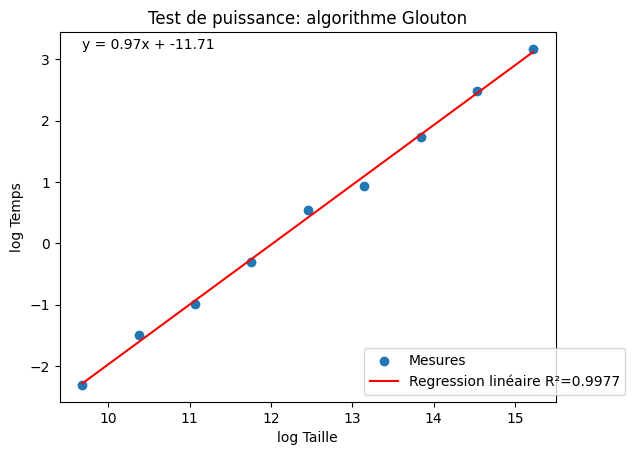

In [ ]:
display_test_puissance(values_test_puissance(measures_glouton), "Test de puissance: algorithme Glouton")

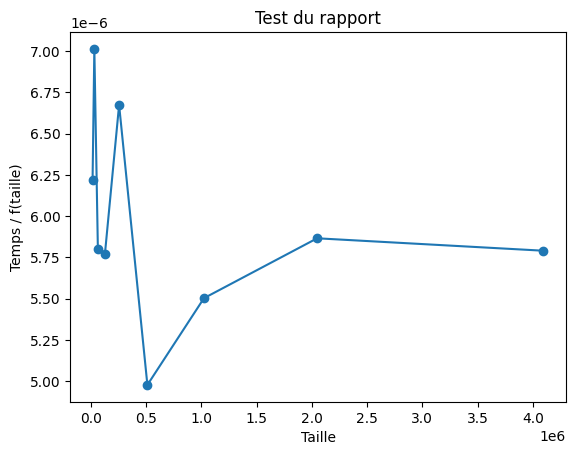

In [ ]:
def f(x):
    return math.pow(x, 1)

display_test_rapport(values_test_rapport(measures_glouton, f))

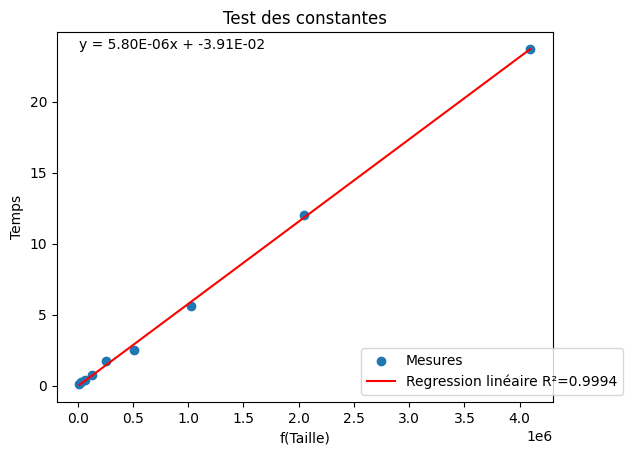

In [ ]:
display_test_constantes(values_test_constantes(measures_glouton, f))

**Test de puissance:**  
On a des points qui suivent bien la droite, donc un algo qui croit de facon polynomial. De plus le taux de croissance est égal a 0.97. Ainsi, ce test nous montre bien que l'algorithme glouton a une complixité linéaire avec la taille de la mélodie (n) se qui confirme l'analyse asymptotique théorique.  

**Test du rapport:**   
À cause du test précedent, nous avons pris comme fonction hypothèse $f = x$. On voit que, vers l'infinie, la droite représenter dans le test du rapport converge vers une valeur autour de $5.75e-06$. Donc, cela confirme que la fonction hypothèse choisi est correct.

**Test des constantes:**
En comparant la fonction $f = x$ avec les valeurs mesurer dans le test des constantes, on obtient la valeur exact de $a = 5.80e-06$. De plus, les points de ce graphique suivent bien la droite se qui vient encore confirmer notre hypothèse.

Cette analyse concorde avec la complexité asymptotique théorique calculé précedemment. En effet, puisque D est petit et constant, on sait que nD sera plus grand que $D^2$, donc que l'algo glouton sera lineaire en fonction de n.

#### Analyse hybride sur D (le nombre de doigt)

Étant donné que la fonction cost assume que le nombre de doigts est toujours égal à 5, il est nécessaire de réecrire l'algorithme glouton mais avec un nombre de doigts spécifié en paramètre. Pour cela, nous allons utiliser une fonction cost aléatoire. Nous supposons qu'elle a une complexité de $\Theta(1)$.

In [16]:
import math
import random

def chooseFirst2Finger(a1, a2, numberOfFinger):
    min = math.inf
    d1 = 0
    d2 = 0
    for i in range(numberOfFinger):
        cost = random.randint(1, numberOfFinger)
        for j in range(numberOfFinger):
            if min > cost:
                min = cost
                d1 = i
                d2 = j
    return d1, d2

def chooseNextFinger(d, a1, a2, numberOfFinger):
    min = math.inf
    minFinger = 0
    for i in range(numberOfFinger):
        cost = random.randint(1, numberOfFinger)
        if min > cost:
                min = cost
                minFinger = i
    return minFinger

def gloutonWithFinger(partition, numberOfFinger):
    solution = []
    firstTwo = chooseFirst2Finger(partition[0], partition[1], numberOfFinger)
    solution.append(firstTwo[0])
    solution.append(firstTwo[1])

    fingerIdx = 1
    while len(solution) != len(partition):
        x = chooseNextFinger(solution[-1], partition[fingerIdx], partition[fingerIdx+1], numberOfFinger)
        solution.append(x)
        fingerIdx += 1

    return solution


Ensuite, nous réecrivons certaines fonctiosn pour prendre en compte ce changement

In [18]:
def measure_with_finger(procedure, sample, finger):
    """ Mesure le temps d'execution d'une procédure sur un unique exemplaire """
    start = time.time()
    solution = procedure(sample, finger)
    end = time.time()
    sorting_time = end - start
    return solution, sorting_time


def measure_mean_time_with_fingers(procedure, samples, finger):
    total_time = 0
    for i in range(len(samples)):
        sample = samples[i]
        _, compute_time = measure_with_finger(procedure, sample, finger)
        total_time += compute_time
        print(f"Computing {procedure.__name__} on sample {i+1} of size {len(sample)}...          ", end='\r')
    return total_time / len(samples)


def measure_procedure_with_fingers(procedure, dataset, fingers):
    """ Mesure les temps moyens d'execution d'une procédure sur chaque point d'un dataset """
    return {finger: measure_mean_time_with_fingers(procedure, samples, finger) for (size, samples), finger in zip(dataset.items(), fingers)}





In [ ]:
dataset = get_dataset(2074487, [48, 49, 50, 51, 52, 53])
fingers = [5000, 10000, 15000, 20000, 25000, 40000]
assert len(fingers) == len(dataset)
measures_gloutonWithFinger = measure_procedure_with_fingers(gloutonWithFinger, dataset, fingers)
display_measures_table(measures_gloutonWithFinger)

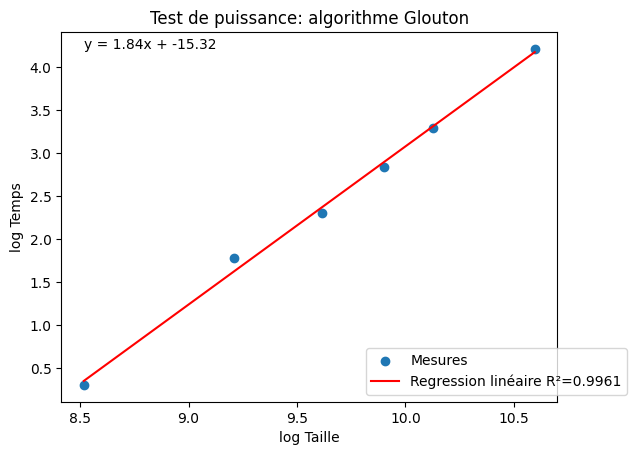

In [ ]:
display_test_puissance(values_test_puissance(measures_gloutonWithFinger), "Test de puissance: algorithme Glouton")

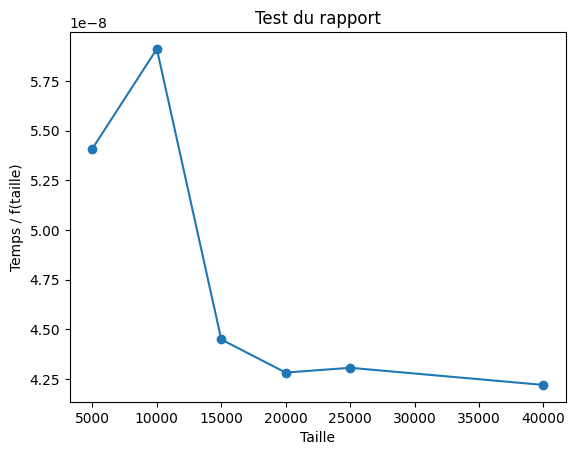

In [ ]:
def f(x):
    return math.pow(x, 2)

display_test_rapport(values_test_rapport(measures_gloutonWithFinger, f))

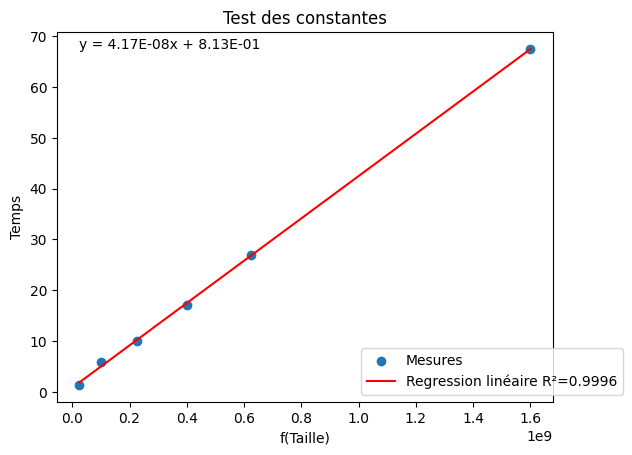

In [ ]:
display_test_constantes(values_test_constantes(measures_gloutonWithFinger, f))

**Test de puissance:**  
On a des points qui suivent bien la droite, donc un algo qui croit de facon polynomial. De plus le taux de croissance est égal a environ 1.84. Donc, ce test nous montre bien que l'algorithme glouton a une complixité de $D^2$ quand on fait croitre le nombre de doigt et qu'on garde n constant.

**Test du rapport:**   
À cause du test précedent, nous avons pris comme fonction hypothèse $f = x^2$. La droite semble se stabiliser vers l'infinie vers une valeur autour de $4.25e-08$

**Test des constantes:**
On obtient la valeur exact de $a = 4.17e-08$. De plus, les points de ce graphique suivent bien la droite se qui vient encore confirmer notre fonction hypothèse.

En conclusion, l'analyse asympotique théorique de notre algotihme glouton nous a donné une compléxité de : $\Theta(\max(D^2, nD))$.
Cela à été confirmer à l'aide d'une analyse hybride sur n (la taille de la mélodie) et sur D (le nombre de doigt)

## Partie 2 : Algorithme de programmation dynamique

L'algorithme de programmation dynamique remplit un tableau des coûts de transition optimaux en
fonction de la mélodie.

Notons `J(k, d)` la somme minimale des coût de transition associée à la mélodie `(ak, ... , an−1)` (c’est-à-
dire au suffixe de longueur `n - k` de la mélodie de départ) où l’on joue la première note ak avec le doigt
d.

Alors, J vérifie la relation de récurrence (1) :

J(k, d) = min { 0≤ d’ ≤ D-1} [ C(ak, d, ak+1, d’ ) + J(k + 1, d’ ) ]

et la condition terminale (2) :

J(n - 1, d) = 0, ∀d = 0, ... , D - 1

Comme on ne connaît pas le premier doigt à utiliser a priori, la solution au problème original est
donnée par (3) :

min { 0 ≤ d ≤ D-1} J(0, d)

Cette récurrence est résolue par programmation dynamique pour déterminer la solution au problème.
Note : Pour vous aider à vérifier que votre implantation fonctionne correctement, voici deux solutions
que vous devriez obtenir avec cet algorithme (dépendant de votre implantation, il pourrait être possible
que vous arriviez au même coût, mais avec une différente suite de doigts) :

- twinkle_twinkle.txt ; coût = 31; doigts = [0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0, 4, 4, 3, 3, 2, 2, 0, 4, 4, 3,
3, 2, 2, 1, 0, 0, 4, 3, 4, 4, 3, 2, 2, 1, 1, 0, 1, 0]

- fur_elise.txt ; coût = 1091; doigts = [1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4,
4, 0, 1, 4, 4, 0, 4, 3, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0,4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0,
1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4,
4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 4, 4, 4, 3,
2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 3, 3, 4, 3, 4, 0, 1, 2, 0, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1,
0, 4, 3, 1, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4,
4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 4, 4]

Implantez l'algorithme de programmation dynamique.

[1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 3, 3, 3, 4, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 2, 0, 1, 2, 0, 1, 0, 2, 1, 1, 0, 4, 4, 4, 3, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 1, 2, 3, 3, 4, 3, 4, 0, 1, 2, 0, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 4, 3, 1, 0, 4, 0, 4, 0, 4, 0, 4, 0, 4, 0, 1, 0, 4, 4, 4, 4, 3, 2, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 1, 3, 4, 0, 4, 0, 1, 0, 1, 0, 4, 4, 4, 0, 1, 4, 4, 0, 4, 3, 0, 1, 2, 3, 4, 0, 4, 4, 4, 0, 4, 4, 4, 0, 4, 4, 

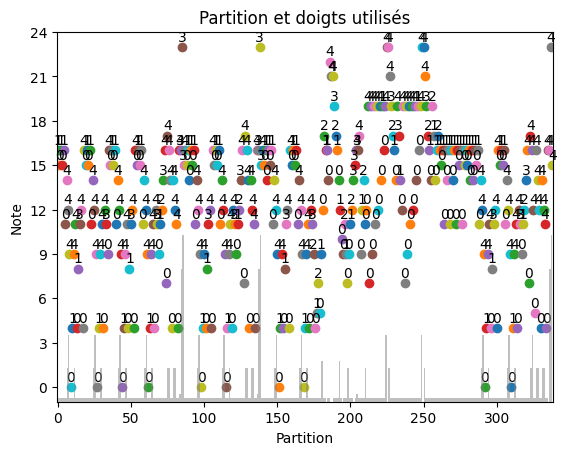

In [ ]:
import math

partition = readFile('Chansons/fur_elise.txt')

def progDyn(partition):
    cal = [[0 for i in range(D)] for j in range(len(partition))]
    solution = []

    #Create the array
    index = len(partition) - 1
    for note in reversed(partition):
        for finger in range(D):
            if (index == len(partition) - 1):
                continue

            min_cost = math.inf
            for previous_finger in range(D):
                cost = costs[note, finger, partition[index + 1], previous_finger]
                if (cal[index + 1][previous_finger] + cost < min_cost):
                    min_cost = cal[index + 1][previous_finger] + cost

            cal[index][finger] = min_cost
        index -= 1

    #Go back through the array
    first_finger = np.argmin(cal[0])
    min_cost = cal[0][first_finger]
    solution.append(first_finger)
    for index in range(1, len(partition)):
        for finger in range(D):
            cost = costs[partition[index - 1], solution[-1], partition[index], finger ]
            if (min_cost == cost + cal[index][finger]):
                min_cost = cal[index][finger]
                solution.append(finger)
                break
    
    return solution


solutionDyn = progDyn(partition)
print(solutionDyn)
print("Coût Programmation Dynamique :", getTotalCost(costs, partition, solutionDyn))
visualize_solution(costs, partition, solutionDyn)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

$$
\text{Il faut d'abord remplir le tableau avec le coût de chaque case: }
$$

$$
\text{Pour chaque note, pour chaque doigt, calculer le coût pour chaque doigt précédent:  } \in \Theta(nD^2)
$$

$$
\text{Ensuite re-traverser le tableau pour obtenir la solution. Il faut calculer quel doigt était le précédent pour chaque note: } \in \Theta(nD)
$$

$$
\text{Donc: } \Theta(nD^2 + nD) = \Theta(nD^2)
$$


### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [ ]:
dataset = get_dataset(2083329, [16000, 32000, 64000, 128000, 256000, 512000, 1024000, 2048000, 4096000])
measures_dyn = measure_procedure(progDyn, dataset)
display_measures_table(measures_dyn)

### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

#### Analyse hybride sur n (taille de la melodie)

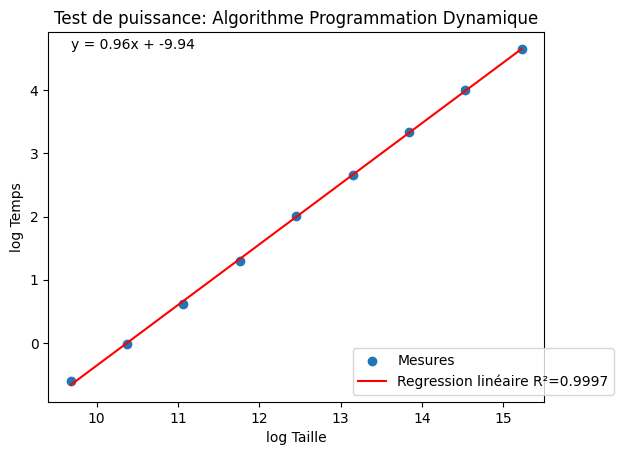

In [ ]:
display_test_puissance(values_test_puissance(measures_dyn), "Test de puissance: Algorithme Programmation Dynamique")

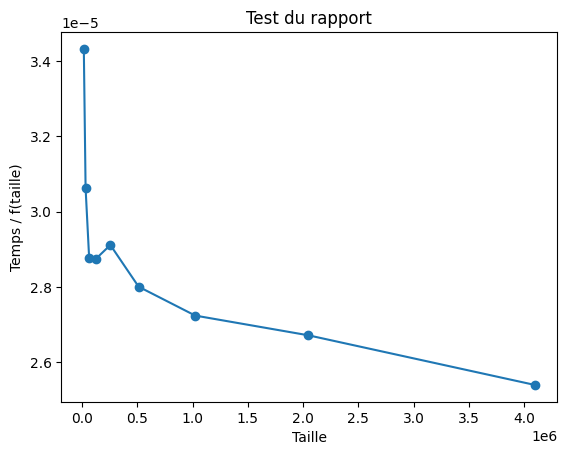

In [ ]:
def f(x):
    return math.pow(x, 1)

display_test_rapport(values_test_rapport(measures_dyn, f))

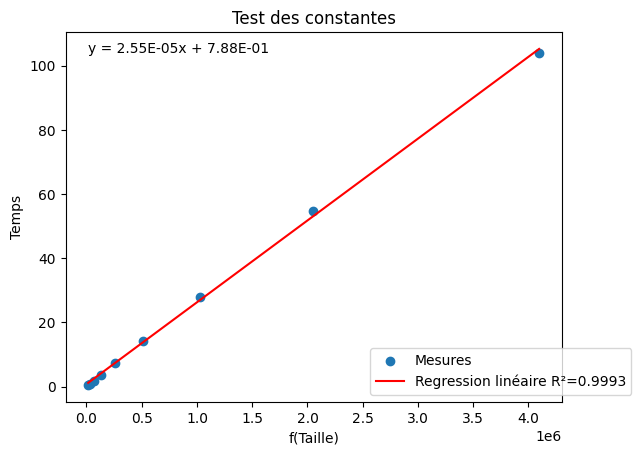

In [ ]:
display_test_constantes(values_test_constantes(measures_dyn, f))

**Test de puissance:**  
On a des points qui suivent bien la droite, donc un algo qui croit de facon polynomial. De plus le taux de croissance est égal a 0.96. Ainsi, ce test nous montre bien que l'algorithme de programmation dynamique a une complexité linéaire avec la taille de la mélodie (n) se qui confirme l'analyse asymptotique théorique.  

**Test du rapport:**   
À cause du test précedent, nous avons pris comme fonction hypothèse $f = x$. On voit que, vers l'infinie, la droite représenter dans le test du rapport converge vers une valeur autour de $2.5e-5$. Donc, cela confirme que la fonction hypothèse choisi est correct.

**Test des constantes:**
En comparant la fonction $f = x$ avec les valeurs mesurer dans le test des constantes, on obtient la valeur exact de $a = 2.55e-05$. De plus, les points de ce graphique suivent bien la droite se qui vient encore confirmer notre hypothèse.

Cette analyse concorde avec la complexité asymptotique théorique calculé précedemment. En effet, puisque $D$ est petit et constant, on sait que $n$ sera le facteur dominant dans la temps d'éxécution. 

#### Analyse hybride sur D (le nombre de doigt)

Étant donné que la fonction cost assume que le nombre de doigts est toujours égal à 5, il est nécessaire de réecrire l'algorithme de programmation dynamique mais avec un nombre de doigts spécifié en paramètre. Pour cela, nous allons utiliser une fonction cost aléatoire. Nous supposons qu'elle a une complexité de $\Theta(1)$.

In [ ]:
import random

def progDynWithFinger(partition, fingers):
    cal = [[0 for i in range(fingers)] for j in range(len(partition))]
    solution = []

    #Create the array
    index = len(partition) - 1
    for note in reversed(partition):
        for finger in range(fingers):
            if (index == len(partition) - 1):
                continue

            min_cost = math.inf
            for previous_finger in range(fingers):
                cost = random.randint(1, fingers)
                if (cal[index + 1][previous_finger] + cost < min_cost):
                    min_cost = cal[index + 1][previous_finger] + cost

            cal[index][finger] = min_cost
        index -= 1

    #Go back through the array
    first_finger = np.argmin(cal[0])
    min_cost = cal[0][first_finger]
    solution.append(first_finger)
    for index in range(1, len(partition)):
        for finger in range(fingers):
            cost = random.randint(1, fingers)
            if (min_cost <= cost + cal[index][finger]):
                min_cost = cal[index][finger]
                solution.append(finger)
                break
    
    return solution

dataset = get_dataset(2083329, [50, 51, 52, 53, 54])
fingers = [10, 100, 1000, 2000, 4000]
assert len(fingers) == len(dataset)
measures_progDynWithFinger = measure_procedure_with_fingers(progDynWithFinger, dataset, fingers)
display_measures_table(measures_progDynWithFinger)


Taille       Temps moyen (s)on sample 5 of size 54...          
10           0.0050028800964355465
100          0.36659584045410154
1000         39.65898494720459
2000         149.67599802017213
4000         613.1186817646027


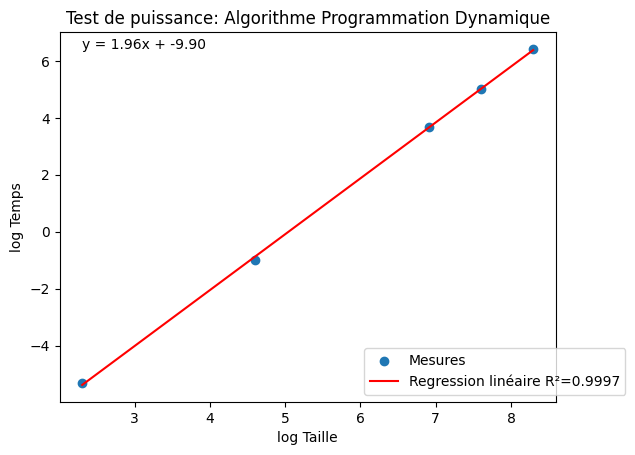

In [ ]:
display_test_puissance(values_test_puissance(measures_progDynWithFinger), "Test de puissance: Algorithme Programmation Dynamique")

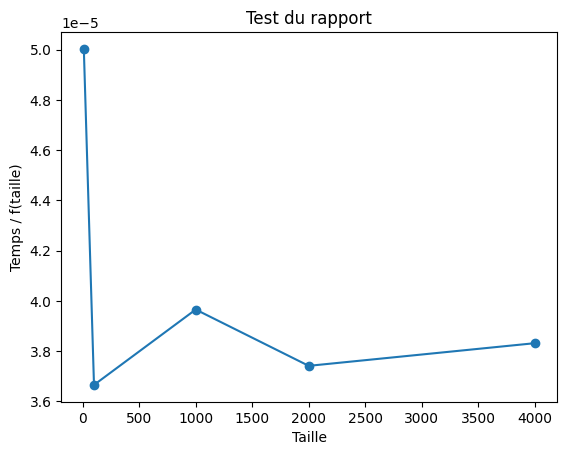

In [ ]:
def f(x):
    return math.pow(x, 2)

display_test_rapport(values_test_rapport(measures_progDynWithFinger, f))

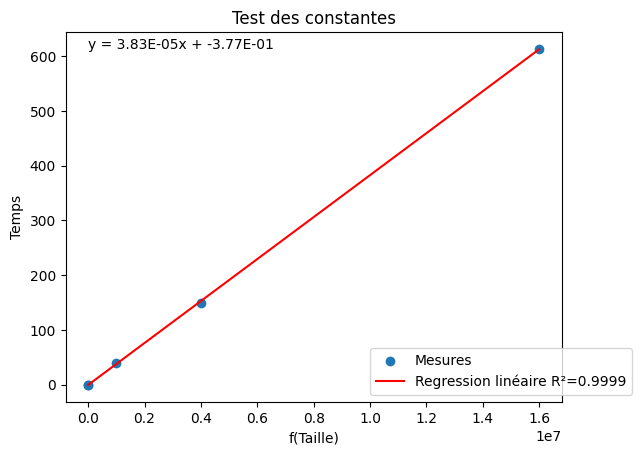

In [ ]:
display_test_constantes(values_test_constantes(measures_progDynWithFinger, f))

**Test de puissance:**  
On a des points qui suivent bien la droite, donc un algo qui croit de facon polynomial. De plus le taux de croissance est égal a 1.96. Ainsi, ce test nous montre bien que l'algorithme de programmation dynamique a une complexité quadratique avec le nombre de doigts (D) se qui confirme l'analyse asymptotique théorique $\Theta(nD^2)$ lorsqu'on garde n constant.  

**Test du rapport:**   
À cause du test précedent, nous avons pris comme fonction hypothèse $f = x^2$. On voit que, vers l'infinie, la droite représenter dans le test du rapport converge vers une valeur autour de $3.9e-5$. Donc, cela confirme que la fonction hypothèse choisi est correct.

**Test des constantes:**
En comparant la fonction $f = x^2$ avec les valeurs mesurer dans le test des constantes, on obtient la valeur exact de $a = 3.83e-05$. De plus, les points de ce graphique suivent bien la droite se qui vient encore confirmer notre hypothèse.

Cette analyse est en concordance avec notre analyse asmyptotique: lorsque le nombre de doigts est constant, l'algorithme croit de manière linéaire avec la taille de la mélodie et lorsque la taille de la mélodie est constante, l'algorithme croit de manière quadratique avec le nombre de doigts disponibles. 

## Partie 3 : Algorithme de recherche locale

Cet algorithme explore le voisinage de solutions non optimales. En partant d’une solution gloutonne, la
solution est améliorée en tentant d’échanger un doigt pour un autre sur une note. Vous pourrez prendre
comme critère d’arrêt un nombre maximal d’itérations.

Coût Recherche Locale : 109


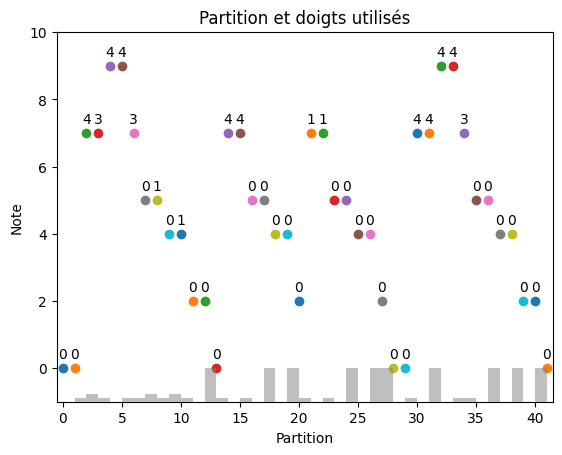

In [7]:
import math

def find_best_neighboor(partition, curr_solution):
    best_neighbor_cost = getTotalCost(costs, partition, curr_solution)
    best_neighbor_solution = curr_solution[:]
    for note_index in range(len(partition)):
            for finger in range(D):
                #if curr_solution[note_index] != finger:
                neighbor_solution = curr_solution[:]
                neighbor_solution[note_index] = finger
                
                neighbor_cost = getTotalCost(costs, partition, neighbor_solution)
                if neighbor_cost < best_neighbor_cost:
                    best_neighbor_cost = neighbor_cost
                    best_neighbor_solution = neighbor_solution

    return best_neighbor_solution, best_neighbor_cost

def localSearch(partition):
    solution = glouton(partition)
    
    max_iterations = 5
    iteration = 0
    while iteration < max_iterations:
        best_solution = solution[:]
        best_cost = getTotalCost(costs, partition, best_solution)

        best_neighbor_solution, best_neighbor_cost = find_best_neighboor(partition, best_solution)
        
        if best_neighbor_cost < best_cost:
            solution = best_neighbor_solution[:]
        
        iteration += 1
    
    
    return solution

solutionLocal = localSearch(partition)
print("Coût Recherche Locale :", getTotalCost(costs, partition, solutionLocal))
visualize_solution(costs, partition, solutionLocal)

### Analyse asymptotique

Dans cette analyse, vous tiendrez compte à la fois de la longueur de la mélodie mais également du
nombre de doigts pour chacun des trois algorithmes.

$$
\text{Il faut d'abord obtenir une solution gloutonne en:} \Theta(\max(D^2, nD))
$$

$$
\text{Ensuite, pour chaque note, pour chaque doigt, calculer le coût de la possible nouvelle solution.  }
$$

$$
\text{Comme calculer le coût total d'une solution ce fait en } \Theta(n) \text{, On obtient } \Theta(n^2D)
$$

$$
\text{Cette dernière étape se fait, au plus, t fois (nombre maximale d'itérations): } \in \Theta(tn^2D)
$$
Mais puisque le nombre d'iteration est une constante et n'est pas une taille d'exemplaire, on ne le prend pas en compte en analyse asymptotique. Donc:  $ \in \Theta(n^2D)$
$$
\text{Donc, la complexité totale devient: } \Theta(\max(D^2, nD, n^2D)) = \Theta(\max(D^2, n^2D))
$$


### Mesures

Rapportez dans un tableau les temps d'exécutions moyens avec les fonctions auxiliaires `measure_procedure` et `display_measure_table`

In [8]:
dataset = get_dataset(2074487, [100, 200, 400, 800, 1600, 3200])
measures_localSearch = measure_procedure(localSearch, dataset)
display_measures_table(measures_localSearch)

Taille       Temps moyen (s)ple 5 of size 3200...          
100          0.10602717399597168
200          0.3230889320373535
400          1.2197391510009765
800          4.126926231384277
1600         15.291094636917114
3200         59.87734007835388


### Validation empirique

Servez-vous de vos temps d'exécution pour confirmer et/ou préciser l'analyse asymptotique théorique de vos algorithmes avec la méthode hybride de votre choix.

La méthode peut varier d'un algorithme à l'autre. Justifiez les choix ici et avec des graphiques.

#### Analyse hybride sur n (taille de la melodie)

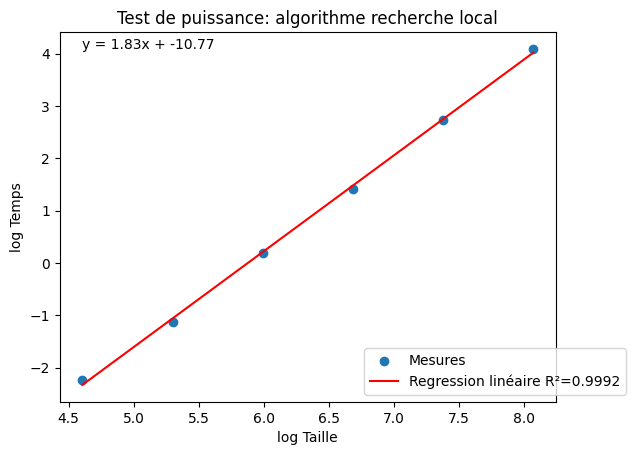

In [9]:
display_test_puissance(values_test_puissance(measures_localSearch), "Test de puissance: algorithme recherche local")

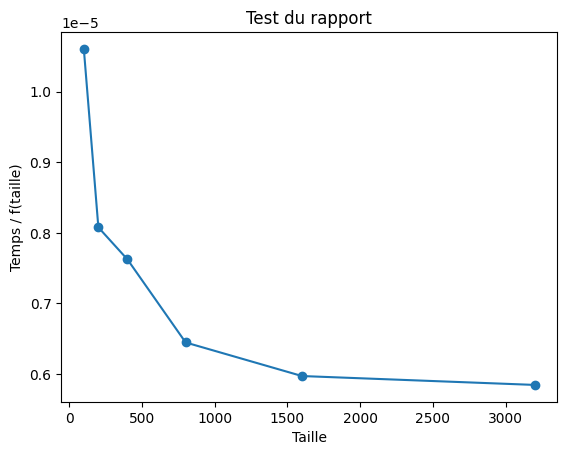

In [10]:
def f(x):
    return math.pow(x, 2)

display_test_rapport(values_test_rapport(measures_localSearch, f)) 

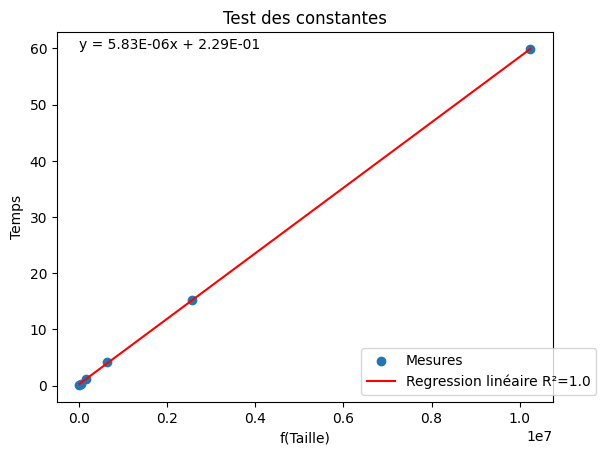

In [11]:
display_test_constantes(values_test_constantes(measures_localSearch, f)) 

**Test de puissance:**  
On a des points qui suivent bien la droite, donc un algo qui croit de facon polynomial. De plus le taux de croissance est égal a 1.83. Ainsi, ce test nous montre bien que l'algorithme de programmation dynamique a une complexité quadratique avec le nombre de notes (n) ce qui confirme l'analyse asymptotique théorique $\Theta(n^2D)$ lorsqu'on garde D constants.  

**Test du rapport:**   
À cause du test précedent, nous avons pris comme fonction hypothèse $f = x^2$. On voit que, vers l'infinie, la droite représenter dans le test du rapport converge vers une valeur autour de $0.6e-5$. Donc, cela confirme que la fonction hypothèse choisi est correct.

**Test des constantes:**
En comparant la fonction $f = x^2$ avec les valeurs mesurer dans le test des constantes, on obtient la valeur exact de $a = 5.83e-06$. De plus, les points de ce graphique suivent bien la droite $(R^2=1.0)$ se qui vient encore confirmer notre hypothèse.

Cette analyse concorde avec la complexité asymptotique théorique calculé précedemment. En effet, puisque $D$ est petit et constant, on sait que $n$ sera le facteur dominant dans la temps d'éxécution. 

#### Analyse hybride sur D (le nombre de doigt)

Étant donné que la fonction cost assume que le nombre de doigts est toujours égal à 5, il est nécessaire de réecrire l'algorithme de programmation dynamique mais avec un nombre de doigts spécifié en paramètre. Pour cela, nous allons utiliser une fonction cost aléatoire. Nous supposons qu'elle a une complexité de $\Theta(1)$.

In [20]:
import random

def find_best_neighboor_fingers(partition, curr_solution, fingers):
    best_neighbor_cost = random.randint(1, len(partition))
    best_neighbor_solution = curr_solution[:]
    for note_index in range(len(partition)):
            for finger in range(fingers):

                neighbor_solution = curr_solution[:]
                neighbor_solution[note_index] = finger
                
                neighbor_cost = random.randint(1, len(partition))
                if neighbor_cost < best_neighbor_cost:
                    best_neighbor_cost = neighbor_cost
                    best_neighbor_solution = neighbor_solution

    return best_neighbor_solution, best_neighbor_cost

def localSearchFingers(partition, fingers):
    solution = gloutonWithFinger(partition, fingers)
    
    max_iterations = 5
    iteration = 0
    while iteration < max_iterations:
        best_solution = solution[:]
        best_cost = random.randint(1, len(partition))
        
        best_neighbor_solution, best_neighbor_cost = find_best_neighboor_fingers(partition, best_solution, fingers)
        
        if best_neighbor_cost < best_cost:
            solution = best_neighbor_solution[:]

        
        iteration += 1
    
    
    return solution

dataset = get_dataset(2074487, [48, 49, 50, 51, 52, 53])
fingers = [5000, 10000, 15000, 20000, 25000, 40000]
assert len(fingers) == len(dataset)
measures_localSearchFingers = measure_procedure_with_fingers(localSearchFingers, dataset, fingers)
display_measures_table(measures_localSearchFingers)

Taille       Temps moyen (s) on sample 5 of size 53...          
5000         2.046080732345581
10000        5.756931114196777
15000        10.70531187057495
20000        17.828322982788087
25000        26.433649349212647
40000        62.85237641334534


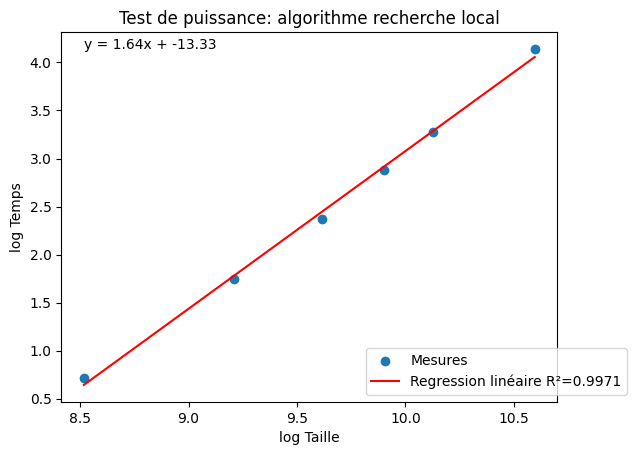

In [21]:
display_test_puissance(values_test_puissance(measures_localSearchFingers), "Test de puissance: algorithme recherche local")

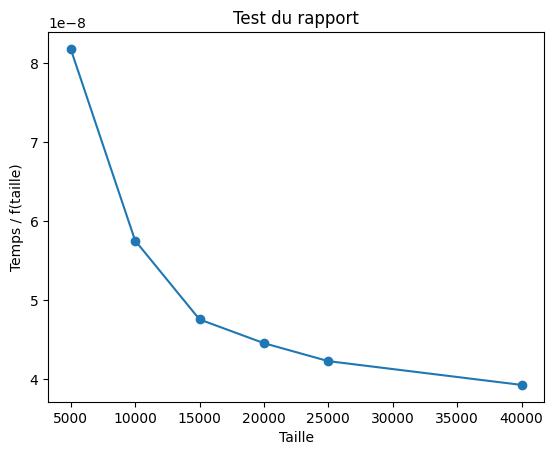

In [22]:
def f(x):
    return math.pow(x, 2)

display_test_rapport(values_test_rapport(measures_localSearchFingers, f)) 

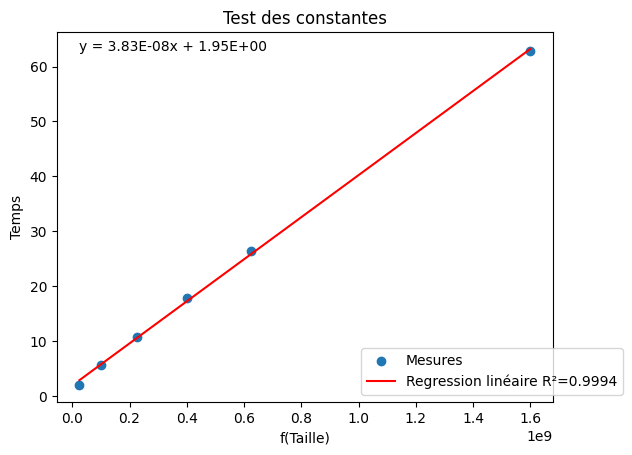

In [24]:
display_test_constantes(values_test_constantes(measures_localSearchFingers, f)) 

**Test de puissance:**  
Ici, nos points suivent plus ou moins la droite. Notre algo devrait croitre de facon polynomial. Le taux de croissance est égal a 1.64 ce qui est un peu loin du résultat attendu, soit 2 . Ce résultat est surtout impressionnant car il montre que l'algorithme de recherche local est supposément plus rapide que l'algorithme glouton ce qui est évidemment impossibe. Tout de même, ce test nous montre que l'algorithme de programmation dynamique est plus proche d'une complexité quadratique que linéaire avec le nombre de doights (D) ce qui confirme l'analyse asymptotique théorique $\Theta(D^2)$ lorsqu'on garde n constant.  

**Test du rapport:**   
À cause du test précedent, nous avons pris comme fonction hypothèse $f = x^2$. On voit que, vers l'infinie, la droite représenter dans le test du rapport converge vers une valeur autour de $4e-8$. Donc, cela confirme que la fonction hypothèse choisi est correct.

**Test des constantes:**
En comparant la fonction $f = x^2$ avec les valeurs mesurer dans le test des constantes, on obtient la valeur exact de $a = 3.83e-08$. De plus, les points de ce graphique suivent bien la droite $(R^2=0.999)$ se qui vient encore confirmer notre hypothèse.

Cette analyse concorde avec la complexité asymptotique théorique calculé précedemment. En effet, puisque $n$ est petit et constant, on sait que $D$ sera le facteur dominant dans la temps d'éxécution. 

# Conclusion et synthèse

Résumez succintement vos résultats et indiquez sous quelles conditions vous utiliseriez chacun des algorithmes.

Nous allons illustrer nos résultat expérimentaux sur un graphique qui va comparer les temps d'exécution à la d'un exemplaire n et D pour nos différents alogrithme

#### Comparaison sur la taille de la mélodie

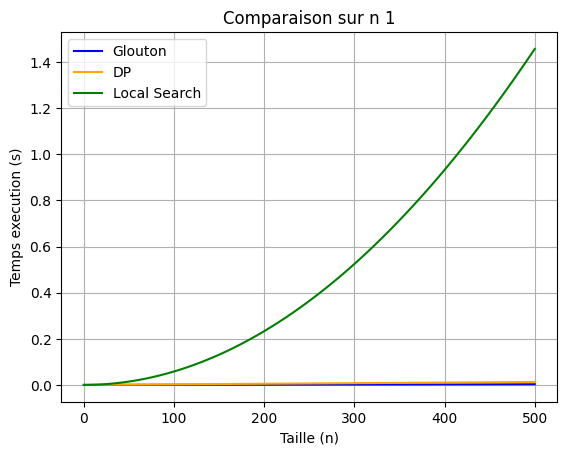

In [28]:
glouton_x = np.linspace(0, 500, 100)
glouton_y = 5.8 * (10**-6) * np.power(glouton_x, 1)  # 5.80e-06
plt.plot(glouton_x, glouton_y, label='Glouton', color='blue')

dp_x = np.linspace(0, 500, 100)
dp_y = 2.55 * (10**-5) * np.power(dp_x, 1) #2.55e-05
plt.plot(dp_x, dp_y, label='DP', color='orange')


localSearch_x = np.linspace(0, 500, 100)
localSearch_y = 5.83 * (10**-6) * np.power(localSearch_x, 2) #5.83e-06
plt.plot(localSearch_x, localSearch_y, label='Local Search', color='green')


plt.xlabel('Taille (n)')
plt.ylabel('Temps execution (s)')
plt.legend()
plt.grid(True)
plt.title('Comparaison sur n 1')
plt.show()


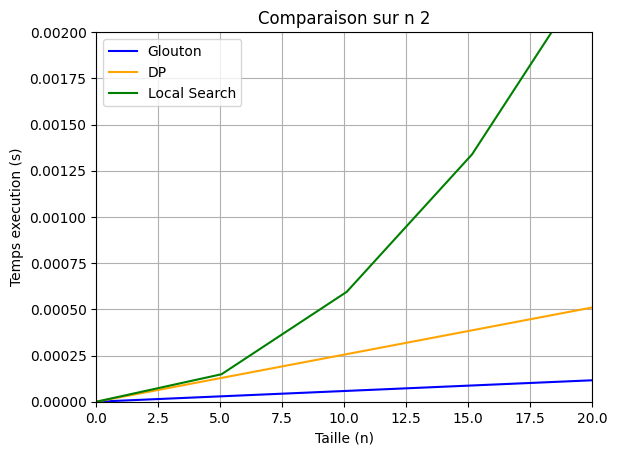

In [29]:
plt.plot(glouton_x, glouton_y, label='Glouton', color='blue')
plt.plot(dp_x, dp_y, label='DP', color='orange')
plt.plot(localSearch_x, localSearch_y, label='Local Search', color='green')

plt.xlabel('Taille (n)')
plt.ylabel('Temps execution (s)')
plt.legend()
plt.grid(True)
plt.xlim(0, 20)
plt.ylim(0, 0.002)
plt.title('Comparaison sur n 2')
plt.show()

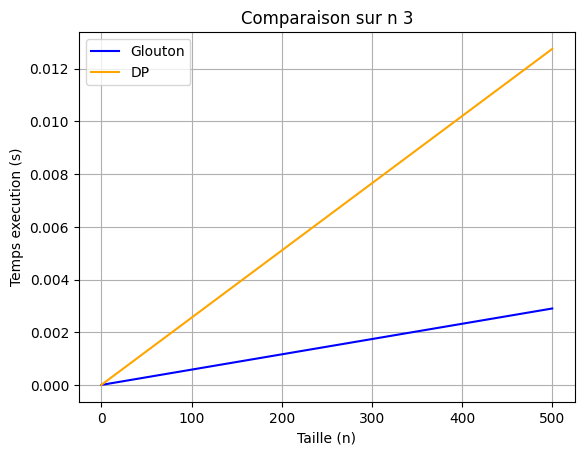

In [30]:
plt.plot(glouton_x, glouton_y, label='Glouton', color='blue')
plt.plot(dp_x, dp_y, label='DP', color='orange')
plt.xlabel('Taille (n)')
plt.ylabel('Temps execution (s)')
plt.legend()
plt.grid(True)
plt.title('Comparaison sur n 3')
plt.show()

**Analyse des Graphiques de copmparaison:**   
Il est bien visible que l'algorithme de recherche local est le pire avec un taux de croissance quadratique. Glouton et programation dynamique on des temps d'execution très comparable pour de petites valeurs, même si l'algorithme glouton reste plus rapide.    


#### Comparaison sur le nombre de doight D

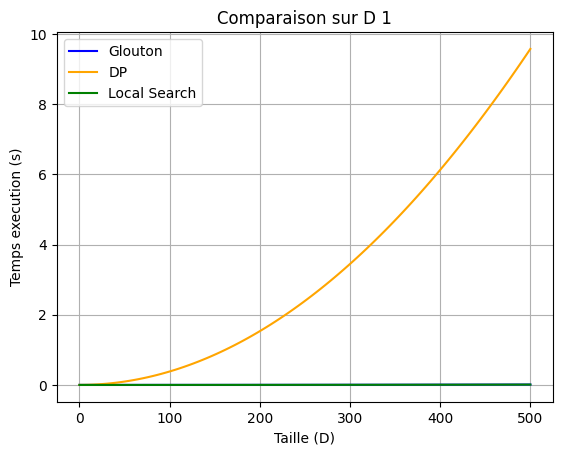

In [33]:
glouton_x_finger = np.linspace(0, 500, 100)
glouton_y_finger = 4.17 * (10**-8) * np.power(glouton_x_finger, 2)  # 4.17e-08
plt.plot(glouton_x_finger, glouton_y_finger, label='Glouton', color='blue')

dp_x_finger = np.linspace(0, 500, 100)
dp_y_finger = 3.83 * (10**-5) * np.power(dp_x_finger, 2) #3.83e-05
plt.plot(dp_x_finger, dp_y_finger, label='DP', color='orange')


localSearch_x_finger = np.linspace(0, 500, 100)
localSearch_y_finger = 3.83 * (10**-8) * np.power(localSearch_x_finger, 2) #3.83e-08
plt.plot(localSearch_x_finger, localSearch_y_finger, label='Local Search', color='green')


plt.xlabel('Taille (D)')
plt.ylabel('Temps execution (s)')
plt.legend()
plt.grid(True)
plt.title('Comparaison sur D 1')
plt.show()


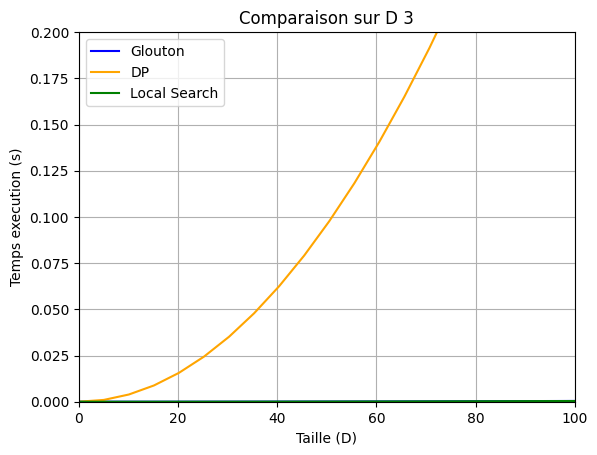

In [36]:
plt.plot(glouton_x_finger, glouton_y_finger, label='Glouton', color='blue')
plt.plot(dp_x_finger, dp_y_finger, label='DP', color='orange')
plt.plot(localSearch_x_finger, localSearch_y_finger, label='Local Search', color='green')
plt.xlabel('Taille (D)')
plt.ylabel('Temps execution (s)')
plt.legend()
plt.grid(True)
plt.xlim(0, 100)
plt.ylim(0, 0.2)
plt.title('Comparaison sur D 3')
plt.show()

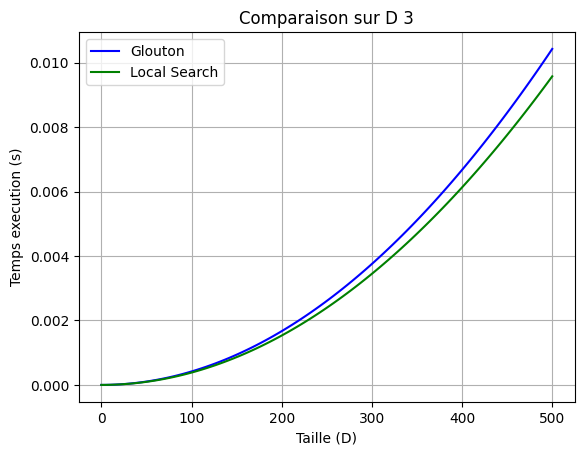

In [37]:
plt.plot(glouton_x_finger, glouton_y_finger, label='Glouton', color='blue')
plt.plot(localSearch_x_finger, localSearch_y_finger, label='Local Search', color='green')
plt.xlabel('Taille (D)')
plt.ylabel('Temps execution (s)')
plt.legend()
plt.grid(True)
plt.title('Comparaison sur D 3')
plt.show()

**Analyse des Graphiques de copmparaison (D):**   
Sur le premier graphique il semble que selon nos résultats l'algorithme de programmation dynamique ai le pire temps d'execution quand D varie. Ensuite, on peut voir que la recherche local et l'algorithme glouton on des temps d'exécution très similaire. 

#### Conclusion des comparaison

Il est important de se rappeler que l'algorithme de programmation dynamique est assuré de données le meilleur résultat pour ce problème. Aussi, en utilisant la recherche local nous obtenons de meilleur résultat que pour gloutons.    
Ainsi voici les conditions d'utilisation de chaque algorithme:    
- Glouton: Si le nombre de doigth est relativement grand par rapport à la taille de la mélodie, qu'il n'est pas nécessaire d'obtenir le meilleur résultat et que le temps d'exécution n'est pas un problème (dans le cas ou $n$ est grand)
- DP: Si le nombre de doigth est relativement petit par rapport à la taille de la mélodie, qu'on veut obtenir le meilleur résultat dans les plus bref délai
- Recherche local: Si le nombre de doigth est relativement grand par rapport à la taille de la mélodie, qu'il n'est pas nécessaire d'obtenir le meilleur résultat, mais qu'on veut un meilleur résultat que glouton sachant que cela prendra un peu plus de temps